# Apple MobileCLIP Evaluation: retrieval metrics

This notebook loads the best Apple MobileCLIP checkpoint, computes image and text embeddings on the validation set,
and reports retrieval metrics (Top-1, Top-5, Top-10).

Ensure you run this from the repository root so relative paths match (or update the paths below).

In [ ]:
# Configuration
from pathlib import Path
import sys
repo_root = Path('..').resolve()  # adjust if running from a different CWD
sys.path.append(str(repo_root))

CHECKPOINT_PATH = Path('checkpoints/best_clipp_apple.pth')
VAL_CSV = Path('../../data/alpaca_mbj_bandgap_test.csv')
BATCH_SIZE = 32
DEVICE = 'cuda' if __import__('torch').cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}, checkpoint: {CHECKPOINT_PATH}')

Using device: cuda, checkpoint: checkpoints/best_clipp.pth


In [2]:
repo_root

PosixPath('/home/jipengsun/MaterialVision/models')

In [3]:
# Imports and model/dataset loading
import torch
import pandas as pd
import open_clip
from torch.utils.data import DataLoader

# Import CLIPP and ImageTextDataset from the training script
from training import CLIPP, ImageTextDataset

# Load MobileCLIP-S2 tokenizer and preprocessor
model_s2, _, preprocess_s2 = open_clip.create_model_and_transforms('MobileCLIP-S2', pretrained='datacompdr')
tokenizer_s2 = open_clip.get_tokenizer('MobileCLIP-S2')

# Initialize model
model = CLIPP(proj_dim=256)
device = torch.device(DEVICE)

# Load checkpoint
assert CHECKPOINT_PATH.exists(), f"Checkpoint not found: {CHECKPOINT_PATH}"
ckpt = torch.load(str(CHECKPOINT_PATH), map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)
model.eval()

# Load validation data
val_df = pd.read_csv(VAL_CSV)
val_ds = ImageTextDataset(val_df, tokenizer_s2, preprocess_s2, train=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
print(f'Validation examples: {len(val_ds)}')

/home/jipengsun/.conda/envs/clipp/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/jipengsun/.conda/envs/clipp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-28 01:59:50,708 INFO: Loaded MobileCLIP-S2 model config.
2025-10-28 01:59:50,708 INFO: Loaded MobileCLIP-S2 model config.
2025-10-28 01:59:52,453 INFO: Loading pretrained MobileCLIP-S2 weights (datacompdr).
2025-10-28 01:59:52,453 INFO: Loading pretrained MobileCLIP-S2 weights (datacompdr).
2025-10-28 01:59:52,653 INFO: Loaded MobileCLIP-S2 model config.
2025-10-28 01:59:52,653 INFO: Loaded MobileCLIP-S2 model config.
2025-10-28 01:59:54,097 INFO: Loading pretrained MobileCLIP-S2 weights (datacomp

Validation examples: 1000


In [4]:
# Compute embeddings for entire validation set
import torch
val_img_embs_list = []
val_txt_embs_list = []
captions = []

with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        text_tokens = batch['text_tokens'].to(device)
        txts = batch['caption']
        
        img_e, txt_e = model(images, text_tokens)
        val_img_embs_list.append(img_e.cpu())
        val_txt_embs_list.append(txt_e.cpu())
        captions.extend(txts)

val_img_embs = torch.cat(val_img_embs_list, dim=0)
val_txt_embs = torch.cat(val_txt_embs_list, dim=0)
print(f'Computed validation embeddings: images {val_img_embs.shape}, texts {val_txt_embs.shape}')

Computed validation embeddings: images torch.Size([1000, 256]), texts torch.Size([1000, 256])


In [5]:
# Compute similarity scores and retrieval metrics
import torch
scores = val_txt_embs @ val_img_embs.T  # (N_text, N_image)

# Top-k metrics as requested
top1 = torch.mean((torch.argmax(scores, dim=1) == torch.arange(scores.shape[0], device=scores.device)).float()).item()
top5 = torch.mean(
    torch.tensor([
        i in torch.topk(scores[i], 5).indices.tolist()
        for i in range(scores.shape[0])
    ], dtype=torch.float32, device=scores.device)
).item()
top10 = torch.mean(
    torch.tensor([
        i in torch.topk(scores[i], 10).indices.tolist()
        for i in range(scores.shape[0])
    ], dtype=torch.float32, device=scores.device)
).item()

print(f"Validation Set Results:")
print(f"Top-1: {top1:.4f}, Top-5: {top5:.4f}, Top-10: {top10:.4f}")

Validation Set Results:
Top-1: 0.1740, Top-5: 0.4330, Top-10: 0.5640


In [6]:
# Compute retrieval metrics on the training set (Top-1 / Top-5 / Top-10)
# WARNING: this computes an N x N similarity matrix and can be memory intensive for large datasets.
TRAIN_CSV = Path('../../data/alpaca_mbj_bandgap_train.csv')
train_df = pd.read_csv(TRAIN_CSV)
train_ds = ImageTextDataset(train_df, tokenizer_s2, preprocess_s2, train=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

train_image_embs = []
train_text_embs = []
with torch.no_grad():
    for batch in train_loader:
        images = batch['image'].to(device)
        text_tokens = batch['text_tokens'].to(device)
        
        img_e, txt_e = model(images, text_tokens)
        train_image_embs.append(img_e.cpu())
        train_text_embs.append(txt_e.cpu())

train_image_embeddings = torch.cat(train_image_embs, dim=0)
train_text_embeddings = torch.cat(train_text_embs, dim=0)
print(f'Computed training embeddings: images {train_image_embeddings.shape}, texts {train_text_embeddings.shape}')

# compute similarity and retrieval metrics for the training set
scores_train = train_text_embeddings @ train_image_embeddings.T  # (N_text, N_image)

# Top-k metrics
train_top1 = torch.mean((torch.argmax(scores_train, dim=1) == torch.arange(scores_train.shape[0], device=scores_train.device)).float()).item()
train_top5 = torch.mean(
    torch.tensor([
        i in torch.topk(scores_train[i], 5).indices.tolist()
        for i in range(scores_train.shape[0])
    ], dtype=torch.float32, device=scores_train.device)
).item()
train_top10 = torch.mean(
    torch.tensor([
        i in torch.topk(scores_train[i], 10).indices.tolist()
        for i in range(scores_train.shape[0])
    ], dtype=torch.float32, device=scores_train.device)
).item()

print(f"Training Set Results:")
print(f"Train Top-1: {train_top1:.4f}, Top-5: {train_top5:.4f}, Top-10: {train_top10:.4f}")

Computed training embeddings: images torch.Size([5000, 256]), texts torch.Size([5000, 256])
Training Set Results:
Train Top-1: 0.3016, Top-5: 0.6372, Top-10: 0.7738
Training Set Results:
Train Top-1: 0.3016, Top-5: 0.6372, Top-10: 0.7738


# Embedding Visualization

Let's visualize how well our Apple MobileCLIP model aligns the image and text embeddings in the shared space using t-SNE dimensionality reduction.

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Ensure plots are displayed inline
%matplotlib inline

# Combine image and text embeddings
combined_embs = torch.cat([val_img_embs, val_txt_embs], dim=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
combined_tsne = tsne.fit_transform(combined_embs.numpy())

# Split back into image and text embeddings
n = len(val_img_embs)
img_tsne = combined_tsne[:n]
txt_tsne = combined_tsne[n:]

# Create visualization
plt.figure(figsize=(15, 15))

# Plot all points
plt.scatter(img_tsne[:, 0], img_tsne[:, 1], c='blue', label='Images', alpha=0.5, s=50)
plt.scatter(txt_tsne[:, 0], txt_tsne[:, 1], c='red', label='Text', alpha=0.5, s=50)

# Draw lines connecting corresponding pairs for a subset of examples
num_examples = 10  # Number of example pairs to highlight
random_indices = np.random.choice(n, num_examples, replace=False)

for i, idx in enumerate(random_indices):
    # Draw a line connecting the image-text pair
    plt.plot([img_tsne[idx, 0], txt_tsne[idx, 0]], 
             [img_tsne[idx, 1], txt_tsne[idx, 1]], 
             'k-', alpha=0.3)
    
    # Add number labels
    plt.annotate(f'Pair {i+1}', 
                xy=(img_tsne[idx, 0], img_tsne[idx, 1]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    plt.annotate(f'Pair {i+1}', 
                xy=(txt_tsne[idx, 0], txt_tsne[idx, 1]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.legend(fontsize=12)
plt.title('t-SNE visualization of image and text embeddings (Apple MobileCLIP-S2)\nValidation Set', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.savefig('apple_mobileclip_tsne.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Performance Analysis

Let's analyze the model performance and compare results with other models.

In [8]:
# Summary of results
import pandas as pd

results_summary = pd.DataFrame({
    'Dataset': ['Validation', 'Training'],
    'Top-1': [top1, train_top1],
    'Top-5': [top5, train_top5],
    'Top-10': [top10, train_top10]
})

print("\n=== Apple MobileCLIP-S2 Performance Summary ===")
print(results_summary.to_string(index=False, float_format='%.4f'))

# Calculate the alignment quality (how close image-text pairs are)
diagonal_scores = torch.diag(scores)
mean_diagonal = diagonal_scores.mean().item()
std_diagonal = diagonal_scores.std().item()

print(f"\n=== Alignment Quality ===")
print(f"Mean similarity score for correct pairs: {mean_diagonal:.4f} ± {std_diagonal:.4f}")
print(f"Max similarity score: {diagonal_scores.max().item():.4f}")
print(f"Min similarity score: {diagonal_scores.min().item():.4f}")


=== Apple MobileCLIP-S2 Performance Summary ===
   Dataset  Top-1  Top-5  Top-10
Validation 0.1740 0.4330  0.5640
  Training 0.3016 0.6372  0.7738

=== Alignment Quality ===
Mean similarity score for correct pairs: 0.5430 ± 0.1844
Max similarity score: 0.8429
Min similarity score: -0.1583


In [9]:
# Show some example retrievals
print("\n=== Example Retrievals ===")

# Get top-5 retrievals for first 5 text queries
num_examples = 5
for i in range(min(num_examples, len(captions))):
    query_text = captions[i]
    similarities = scores[i]
    top5_indices = torch.topk(similarities, 5).indices.tolist()
    
    print(f"\nQuery {i+1}: {query_text}")
    print(f"Top-5 retrieved images (by similarity):")
    for rank, img_idx in enumerate(top5_indices):
        sim_score = similarities[img_idx].item()
        correct = "✓" if img_idx == i else "✗"
        print(f"  Rank {rank+1}: Image {img_idx} (similarity: {sim_score:.4f}) {correct}")


=== Example Retrievals ===

Query 1: LiGeS 0.0
Top-5 retrieved images (by similarity):
  Rank 1: Image 941 (similarity: 0.7235) ✗
  Rank 2: Image 888 (similarity: 0.7202) ✗
  Rank 3: Image 340 (similarity: 0.7067) ✗
  Rank 4: Image 635 (similarity: 0.7065) ✗
  Rank 5: Image 708 (similarity: 0.7001) ✗

Query 2: PrTeCl 0.88
Top-5 retrieved images (by similarity):
  Rank 1: Image 523 (similarity: 0.5752) ✗
  Rank 2: Image 376 (similarity: 0.5650) ✗
  Rank 3: Image 501 (similarity: 0.5420) ✗
  Rank 4: Image 881 (similarity: 0.5401) ✗
  Rank 5: Image 959 (similarity: 0.5302) ✗

Query 3: FeSb4O12 0.0
Top-5 retrieved images (by similarity):
  Rank 1: Image 2 (similarity: 0.6900) ✓
  Rank 2: Image 371 (similarity: 0.5653) ✗
  Rank 3: Image 425 (similarity: 0.5477) ✗
  Rank 4: Image 555 (similarity: 0.5375) ✗
  Rank 5: Image 234 (similarity: 0.5345) ✗

Query 4: VS2 0.0
Top-5 retrieved images (by similarity):
  Rank 1: Image 200 (similarity: 0.5555) ✗
  Rank 2: Image 192 (similarity: 0.5512) ✗


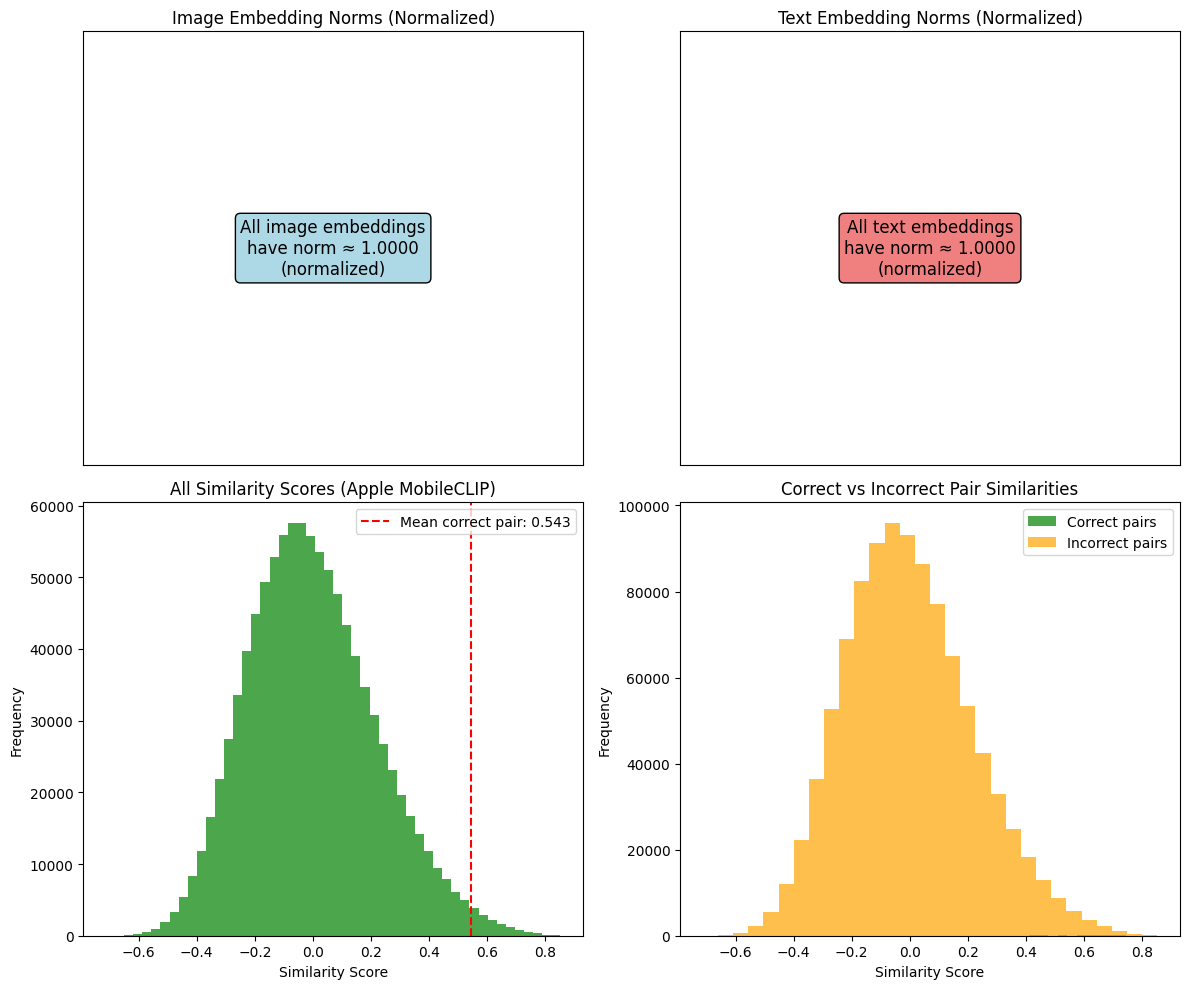

Average image embedding norm: 1.0000 (range: 0.000000)
Average text embedding norm: 1.0000 (range: 0.000000)
Average off-diagonal similarity: -0.0021
Diagonal scores range: -0.1583 to 0.8429
Off-diagonal scores range: -0.7129 to 0.8518


In [17]:
# Analyze embedding distributions
import matplotlib.pyplot as plt

# Ensure plots are displayed inline
%matplotlib inline

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Image embedding norms
img_norms = torch.norm(val_img_embs, dim=1)
# Check if all norms are very similar (normalized embeddings)
img_norm_range = img_norms.max() - img_norms.min()
if img_norm_range < 1e-6:
    # All norms are essentially the same - show a text message instead of histogram
    axes[0,0].text(0.5, 0.5, f'All image embeddings\nhave norm ≈ {img_norms.mean():.4f}\n(normalized)', 
                   ha='center', va='center', transform=axes[0,0].transAxes, fontsize=12, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    axes[0,0].set_title('Image Embedding Norms (Normalized)')
    axes[0,0].set_xlim(0, 1)
    axes[0,0].set_ylim(0, 1)
    axes[0,0].set_xticks([])
    axes[0,0].set_yticks([])
else:
    axes[0,0].hist(img_norms.numpy(), bins=30, alpha=0.7, color='blue')
    axes[0,0].set_title('Image Embedding Norms')
    axes[0,0].set_xlabel('L2 Norm')
    axes[0,0].set_ylabel('Frequency')

# Text embedding norms
txt_norms = torch.norm(val_txt_embs, dim=1)
txt_norm_range = txt_norms.max() - txt_norms.min()
if txt_norm_range < 1e-6:
    # All norms are essentially the same - show a text message instead of histogram
    axes[0,1].text(0.5, 0.5, f'All text embeddings\nhave norm ≈ {txt_norms.mean():.4f}\n(normalized)', 
                   ha='center', va='center', transform=axes[0,1].transAxes, fontsize=12,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
    axes[0,1].set_title('Text Embedding Norms (Normalized)')
    axes[0,1].set_xlim(0, 1)
    axes[0,1].set_ylim(0, 1)
    axes[0,1].set_xticks([])
    axes[0,1].set_yticks([])
else:
    axes[0,1].hist(txt_norms.numpy(), bins=30, alpha=0.7, color='red')
    axes[0,1].set_title('Text Embedding Norms')
    axes[0,1].set_xlabel('L2 Norm')
    axes[0,1].set_ylabel('Frequency')

# Similarity score distribution
all_scores = scores.flatten()
axes[1,0].hist(all_scores.numpy(), bins=50, alpha=0.7, color='green')
axes[1,0].axvline(mean_diagonal, color='red', linestyle='--', label=f'Mean correct pair: {mean_diagonal:.3f}')
axes[1,0].set_title('All Similarity Scores (Apple MobileCLIP)')
axes[1,0].set_xlabel('Similarity Score')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# Diagonal vs off-diagonal scores
off_diagonal_mask = ~torch.eye(scores.size(0), dtype=bool)
off_diagonal_scores = scores[off_diagonal_mask]

# Use adaptive binning for similarity scores
diag_range = diagonal_scores.max() - diagonal_scores.min()
off_diag_range = off_diagonal_scores.max() - off_diagonal_scores.min()
diag_bins = max(5, min(30, int(diag_range * 100)))  # Adaptive binning
off_diag_bins = max(5, min(30, int(off_diag_range * 100)))

axes[1,1].hist(diagonal_scores.numpy(), bins=diag_bins, alpha=0.7, label='Correct pairs', color='green')
axes[1,1].hist(off_diagonal_scores.numpy(), bins=off_diag_bins, alpha=0.7, label='Incorrect pairs', color='orange')
axes[1,1].set_title('Correct vs Incorrect Pair Similarities')
axes[1,1].set_xlabel('Similarity Score')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('apple_mobileclip_embedding_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Average image embedding norm: {img_norms.mean():.4f} (range: {img_norm_range:.6f})")
print(f"Average text embedding norm: {txt_norms.mean():.4f} (range: {txt_norm_range:.6f})")
print(f"Average off-diagonal similarity: {off_diagonal_scores.mean():.4f}")
print(f"Diagonal scores range: {diagonal_scores.min().item():.4f} to {diagonal_scores.max().item():.4f}")
print(f"Off-diagonal scores range: {off_diagonal_scores.min().item():.4f} to {off_diagonal_scores.max().item():.4f}")